In [1]:
import nvidia
import nvidia.cudnn
print(nvidia.cudnn.__file__)

/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/nvidia/cudnn/__init__.py


In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2024-05-02 12:39:50.496085: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 12:39:50.524119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 12:39:50.997081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-02 12:39:51.460253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 12:39:51.480757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 12:39:51.480871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from typing import List
from matplotlib import pyplot as plt
import numpy as np

from importlib import reload
import pisces.models as pm

from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs
import matplotlib.pyplot as plt

from pisces.data_sets import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
walch = sets['walch_et_al']
hybrid = sets['hybrid_motion']

2024-05-02 12:39:52.199204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 12:39:52.199345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 12:39:52.199432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:

mo = pm.MOResUNetPretrained(sampling_hz=32)


In [5]:
from sklearn.metrics import auc as area
def roc_for_class(X, y, neg_class: int):
    pr = mo.predict_probabilities(X)[0]
    p_not_class = 1 - pr[:, neg_class]
    y_padded = np.zeros_like(p_not_class)
    mask = np.zeros_like(p_not_class)
    # just score the class
    y_padded[:y.shape[0]] = y != neg_class
    # PSG with negative value indicates to ignore that epoch
    mask[:y.shape[0]] = y >= 0
    
    return pm.roc_curve(y_padded, p_not_class, sample_weight=mask)

class_names = ['Wake', 'Light', 'Deep', 'REM']
def accuracy_for_class(X, y, mo_net: pm.MOResUNetPretrained, class_: int | None = None, class_name: str | None = None):
    if class_ is None:
        class_ = class_names.index(class_name)
    
    pr = mo_net.predict_probabilities(X)[0]
    # mask = np.zeros_like(p_not_class)
    max_likelihood = pr.argmax(axis=1)
    y_padded = np.zeros_like(max_likelihood)
    y_padded[:y.shape[0]] = y
    mask = np.zeros_like(max_likelihood)
    # PSG with negative value indicates to ignore that epoch
    mask[:y.shape[0]] = y >= 0

    # total matches for class / total examples

    return np.sum((max_likelihood == y_padded) & (y_padded == class_) & mask) / max(np.sum(y == class_), 1)


# Walch et al. data set

## (MO) Pretrained UNet evaluation
We have the trained weights from Mads Olsen et al.'s _ResUNet_ model, saved as a tensorflow lite model with a wrapper for our system. This section calls that on accelerometer recordings in the `'walch_et_al'` data set.

In [6]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
evaluations_walch, mo_preprocessed_data_walch = mo.evaluate_data_set(walch)
mo_aucs_walch = [e["auc"] for e in evaluations_walch.values()]
mo_fprs_walch = [e["roc_curve"]["fprs"] for e in evaluations_walch.values()]
mo_tprs_walch = [e["roc_curve"]["tprs"] for e in evaluations_walch.values()]


Using 12 of 12 cores (100%) for parallel preprocessing.
This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)
getting needed X, y for 1818471getting needed X, y for 2638030getting needed X, y for 2598705getting needed X, y for 1455390getting needed X, y for 3997827getting needed X, y for 4018081getting needed X, y for 4314139getting needed X, y for 3509524

getting needed X, y for 4426783








getting needed X, y for 1066528getting needed X, y for 1360686

getting needed X, y for 1449548
sampling hz:sampling hz: sampling hz:32
masking  3232
masking


maskingsampling hz:
 Masked 1 PSG epochs
sampling hz:sampling hz:sampling hz: 32
  32
32masking32sampling hz:masking

maskingresampling to 32Hz (0.03125s) from 66 Hz (0.01501s)


 
sampling hz:32masking 
masking
Masked 1 PSG epochs
Masked 1 PSG epochs32

masking

sampling hz: sampling hz: 3232sampling hz:
 
maskingmasking32
Masked 1 PSG epochs
Masked 1 PSG epochs

masking
resampling to 32Hz (0.03125s) from 50 Hz (0.01998s)Masked 2 PSG epochsMasked 1 PSG epochs

resampling to 32Hz (0.03125s) from 66 Hz (0.01502s)

Masked 1 PSG epochs

resampling to 32Hz (0.03125s) from 50 Hz (0.01988s)resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)Masked 1 PSG epochsresampling to 32Hz (0.03125s) from 49 Hz (0.02001s)Masked 1 PSG epochs
Masked 1 PSG epochs



resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)Masked 1 PSG epochs

resampling to

In [7]:
X_0, y_0 = mo_preprocessed_data_walch[0][0]

fpr_pre, tpr_pre, thr_pre = roc_for_class(X_0, y_0, 0)

I0000 00:00:1714671626.554218  530392 service.cc:145] XLA service 0x739ff4032a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714671626.554241  530392 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-02 12:40:26.581201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-02 12:40:26.704532: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1714671628.788160  530392 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [20]:
def print_accuracy_summary(X_0, y_0, mo_net) -> List[float]:
    class_accuracies = []
    for class_no in range(4):
        class_accuracies.append(
            accuracy_for_class(X_0, y_0, mo_net, class_no))
    for class_no in range(4):
        print(f"Accuracy for {class_names[class_no]} is\t{class_accuracies[class_no]:.3f}")
    return class_accuracies

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


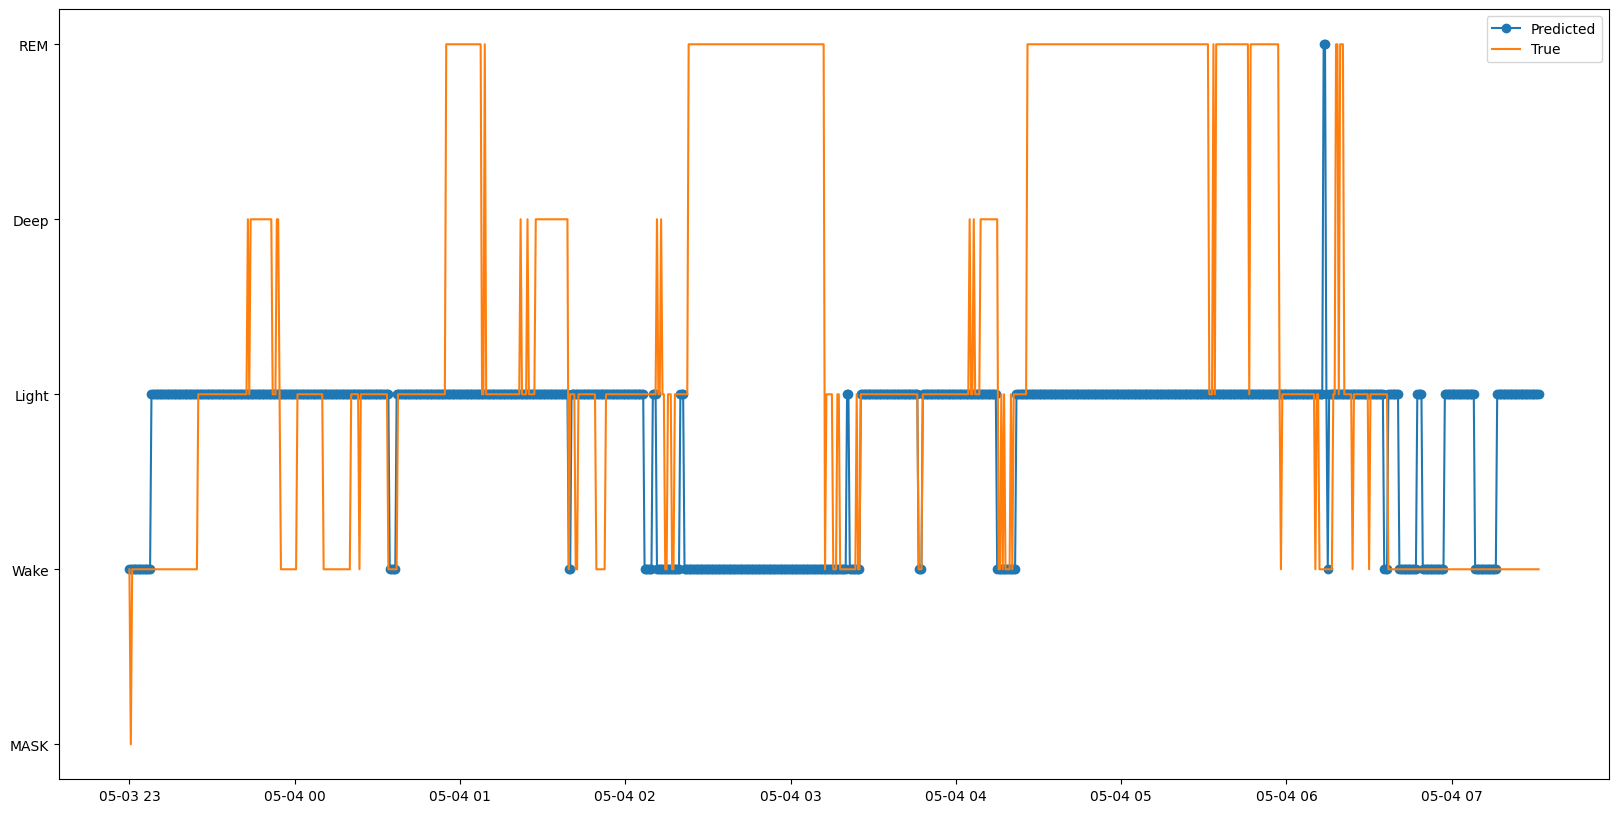

In [9]:
pr_hat = mo.predict_probabilities(X_0)[0]
y_0_hat = np.argmax(pr_hat, axis=1)
y_0_pad = np.zeros_like(y_0_hat)
y_0_pad[:y_0.shape[0]] = y_0

plt.figure(figsize=(20, 10))

# make a numpy datetime array starting at May 3, 2024 and having one entry every 30 seconds for len(y_0_pad) entries
# this is just for the x-axis
from datetime import datetime, timedelta

dt = datetime(2024, 5, 3, 23)
x_time = np.array([dt + timedelta(seconds=30 * i) for i in range(len(y_0_pad))])

# PSG with negative value indicates to ignore that epoch
plt.plot(x_time, y_0_hat, "o-")
plt.plot(x_time, y_0_pad)#, "o-")

y_labels =[
    "MASK",
    *class_names
    # "Wake",a
    # "Light",
    # "Deep",
    # "REM"
]



plt.yticks([r - 1 for r in range(len(y_labels))], y_labels)

plt.legend(["Predicted", "True"])

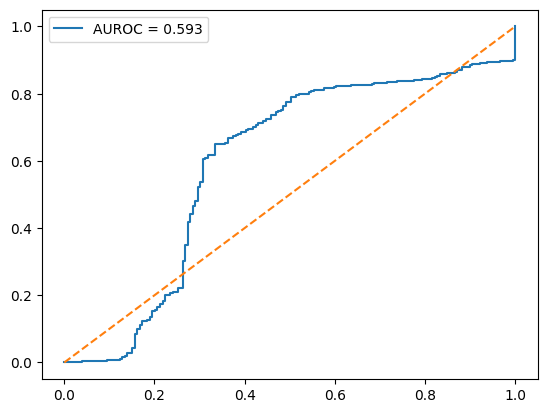

In [10]:
plt.plot(fpr_pre, tpr_pre, label=f"AUROC = {area(fpr_pre, tpr_pre):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.legend()

In [11]:
x = np.array([[1.0, 2, 3]])
print(x)
print(
    np.pad(
        x,
        pad_width=[
            (2, 1),
            (0, 3),
        ]
    )
)

[[1. 2. 3.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 2. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [12]:
from sklearn.model_selection import LeaveOneOut


reload(pm)

trained_mos = []
evaluated_test_sets = []

break_up_line = "=" * 20

for train, test in LeaveOneOut().split(range(len(mo_preprocessed_data_walch))):
    print(f"\n\n{break_up_line}\nTest index {test}, subject {walch.ids[test[0]]}")
    mo_pre = pm.MOResUNetPretrained()

    print("PRE-TRAINING")
    X_test, y_test = mo_preprocessed_data_walch[test[0]][0]
    print_accuracy_summary(X_test, y_test, mo_pre)
    print(break_up_line)

    mo_run = pm.run_split(
        train_indices=train,
        preprocessed_data_set=mo_preprocessed_data_walch,
        swc=mo_pre,
        epochs=20
    )

    print("POST-TRAINING")
    # y_prob = mo_run.predict_probabilities(mo_preprocessed_data_walch[test[0]][0][0])[0]
    print_accuracy_summary(X_test, y_test, mo_run)

    trained_mos.append(mo_run)



Test index [0], subject 1066528
PRE-TRAINING
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy for Wake is	0.413
Accuracy for Light is	0.907
Accuracy for Deep is	0.000
Accuracy for REM is	0.000
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - loss: 1.6830 - val_loss: 0.9462
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.8309 - val_loss: 0.9191
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.6879 - val_loss: 0.9139
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.6480 - val_loss: 0.8997
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.5188 - val_loss: 0.8825
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.5493 - val_loss: 0.8652
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.4637 - val_loss: 0.8492
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.2779 - val_loss: 0.8564
Epoch 9/20
27

In [16]:
len(mo_preprocessed_data_walch)

31

In [17]:
len(trained_mos)

31

In [27]:
import polars as pl 

pre_accuracies = []
accuracies = []
for index, ((X, y), id) in enumerate(mo_preprocessed_data_walch):
    pre_accuracies.append(print_accuracy_summary(X, y, pm.MOResUNetPretrained()))
    accuracies.append(print_accuracy_summary(X, y, trained_mos[index]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy for Wake is	0.419
Accuracy for Light is	0.715
Accuracy for Deep is	0.290
Accuracy for REM is	0.783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy for Wake is	0.419
Accuracy for Light is	0.715
Accuracy for Deep is	0.290
Accuracy for REM is	0.783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy for Wake is	0.675
Accuracy for Light is	0.693
Accuracy for Deep is	0.043
Accuracy for REM is	0.447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy for Wake is	0.675
Accuracy for Light is	0.693
Accuracy for Deep is	0.043
Accuracy for REM is	0.44

In [28]:
# organize per-column by zipping these all together
accuracies = list(zip(*accuracies))
acc_df = pl.DataFrame({class_names[j]: accuracies[j] for j in range(len(class_names))})

pre_accuracies = list(zip(*pre_accuracies))
pre_acc_df = pl.DataFrame({class_names[j]: pre_accuracies[j] for j in range(len(class_names))})

In [29]:
acc_df.head()

Wake,Light,Deep,REM
f64,f64,f64,f64
0.418994,0.714646,0.290323,0.783172
0.675214,0.693478,0.042945,0.447115
0.230769,0.836957,0.986111,0.772321
0.25,0.701881,0.0,0.955556
0.9,0.769625,0.373239,0.945455


In [30]:
acc_df.describe()

statistic,Wake,Light,Deep,REM
str,f64,f64,f64,f64
"""count""",31.0,31.0,31.0,31.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.538383,0.74082,0.517542,0.700047
"""std""",0.267959,0.108196,0.291673,0.272667
"""min""",0.026316,0.475129,0.0,0.0
"""25%""",0.349593,0.682984,0.351852,0.628571
"""50%""",0.510638,0.755172,0.530303,0.765799
"""75%""",0.787879,0.834171,0.767442,0.916667
"""max""",0.938776,0.90835,1.0,1.0


In [31]:
pre_acc_df.describe()

statistic,Wake,Light,Deep,REM
str,f64,f64,f64,f64
"""count""",31.0,31.0,31.0,31.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.538383,0.74082,0.517542,0.700047
"""std""",0.267959,0.108196,0.291673,0.272667
"""min""",0.026316,0.475129,0.0,0.0
"""25%""",0.349593,0.682984,0.351852,0.628571
"""50%""",0.510638,0.755172,0.530303,0.765799
"""75%""",0.787879,0.834171,0.767442,0.916667
"""max""",0.938776,0.90835,1.0,1.0
